# From Bayes to BERT: Classification Approaches in NLP
***
[Alejandro Ciuba](https://alejandrociuba.github.io), alejandrociuba@pitt.edu
***
## Summary

This presentation looks at the various ways we can build and develop NLP pipelines for text classification tasks like author identification and sentiment analysis. The presentation plans to cover the following approaches:

1. Simple Knowledge Bases using Forward and Backward Chaining
    - Who wrote it: Jane Austen or Herman Melville?
2. Naive Bayes Classifier
3. K-Nearest Neighbors
4. Support Vector Machine
5. Logistic Regression
6. Simple Feed-Forward Neural Network
7. Recurrent Neural Network
8. Long-Short Term Memory Network
9. Gated Recurrent Unit Network
10. Simple Transformer
11. HuggingFace Classifiers
***
## Necessary Imports & Setup

In [39]:
# These imports are required to run the notebook
from pathlib import Path
from sklearn.metrics import (accuracy_score,
                             precision_score,
                             recall_score,
                             f1_score,
                             confusion_matrix,)

import nltk
import os

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

### Load The Datasets

In [14]:
PATH = "./datasets/"
df = pd.read_pickle(PATH + "dataset.pkl")

# Create a tokenized word column
df["line"] = df["line"].map(lambda x: x.lower())
df["tokens"] = df["line"].map(nltk.word_tokenize)

df.sample(10)


,author,book,line,tokens
251653,tolstoy,anna_karenina,“i’ll go away tomorrow ... i’ll do more.,"[“, i, ’, ll, go, away, tomorrow, ..., i, ’, l..."
131324,tolstoy,war_and_peace,everyone stood up respectfully when the milita...,"[everyone, stood, up, respectfully, when, the,..."
203498,tolstoy,war_and_peace,"“always some fantastic schemes,” said nicholas.","[“, always, some, fantastic, schemes, ,, ”, sa..."
149423,tolstoy,war_and_peace,"“don’t stint yourself, we’ll settle afterwards...","[“, don, ’, t, stint, yourself, ,, we, ’, ll, ..."
231809,tolstoy,anna_karenina,“you must ask the doctor to examine the wet-nu...,"[“, you, must, ask, the, doctor, to, examine, ..."
248634,tolstoy,anna_karenina,but this lasted only an instant.,"[but, this, lasted, only, an, instant, .]"
78568,melville,moby_dick,my jack-knife here needs the grindstone.,"[my, jack-knife, here, needs, the, grindstone, .]"
151955,tolstoy,war_and_peace,after the field marshal’s departure it appears...,"[after, the, field, marshal, ’, s, departure, ..."
12862,austen,mansfield_park,"the admiral delighted in the boy, mrs. crawfor...","[the, admiral, delighted, in, the, boy, ,, mrs..."
12249,austen,mansfield_park,"as for fanny’s being stupid at learning, “she ...","[as, for, fanny, ’, s, being, stupid, at, lear..."


## Useful Helper Functions

In [34]:
def get_metrics(targets, predictions):

    acc = accuracy_score(y_true=targets, y_pred=predictions)
    prec = precision_score(y_true=targets, y_pred=predictions, average="macro")
    rec = recall_score(y_true=targets, y_pred=predictions, average="macro")
    f1 = f1_score(y_true=targets, y_pred=predictions, average="macro")
    conf = confusion_matrix(y_true=targets, y_pred=predictions)

    return acc, prec, rec, f1, conf

In [41]:
def plot_confusion_matrix(cm, labels):   
    sns.heatmap(cm, square=True, annot=True, fmt='d', cbar=True, cmap="Reds", 
                xticklabels=labels, yticklabels=labels)
    plt.xlabel('predicted label')
    plt.ylabel('true label')
    plt.show()

### Ignore The Knowledge Base Implementation

The knowledge base was modified from a previous homework I did for *CS2710: Foundations in AI*, and as such I will not be uploading it to the repository. Please run this to ignore the cells that require this import

In [3]:
ALEJANDRO = True  # I'm me, lol

if ALEJANDRO:    
    from kb.Propositional_KB_agent import *


***
## Simple Knowledge Base

While not necessarily used for classification, knowledge bases are a way to represent given rules (implications [`p -> q`]) and facts (literals [`p`]) about a *domain of discourse,* a group of objects. From these rules and facts, we can algorithmically deduce new rules (forward chaining) or prove new theorems (backward chaining).

In [4]:
# Get all the sentences for Emma and Moby Dick
if ALEJANDRO:
    kb_df = df[(df.book == "emma") | (df.book == "moby_dick")]
    kb_df.sample(10)

In [5]:
# Define the rules for Jane Austen and Herman Melville
if ALEJANDRO:
    austen = {'Emma', 'Harriet', 'Weston', 'Knightley', 
            'Elton','Woodhouse', 'Jane', 'Fairfax', 
            'Churchill', 'Frank', 'Hartfield', 'Bates', 
            'Highbury', 'Perry', 'Cole', 'Goddard', 
            'Campbell', 'Donwell', 'Dixon', 'Taylor',}

    melville = {'Ahab','Queequeg', 'Pequod', 'Bildad', 
                'Stubb', 'Starbuck', 'Peleg', 'Pip', 
                'Tashtego', 'Charley'}

    austen = [Rule(f"R{i}", [name.lower()], "emma") for i, name in enumerate(austen)]
    melville = [Rule(f"R{i}", [name.lower()], "moby_dick") for i, name in enumerate(melville)]

    kb_austen = KB(init_RB=austen)
    kb_melville = KB(init_RB=melville)

In [6]:
if ALEJANDRO:
    kb_austen.print_RB()

R0
If: ['perry']
Then: emma
 
R1
If: ['frank']
Then: emma
 
R2
If: ['jane']
Then: emma
 
R3
If: ['churchill']
Then: emma
 
R4
If: ['hartfield']
Then: emma
 
R5
If: ['elton']
Then: emma
 
R6
If: ['emma']
Then: emma
 
R7
If: ['weston']
Then: emma
 
R8
If: ['knightley']
Then: emma
 
R9
If: ['bates']
Then: emma
 
R10
If: ['dixon']
Then: emma
 
R11
If: ['goddard']
Then: emma
 
R12
If: ['highbury']
Then: emma
 
R13
If: ['woodhouse']
Then: emma
 
R14
If: ['donwell']
Then: emma
 
R15
If: ['campbell']
Then: emma
 
R16
If: ['fairfax']
Then: emma
 
R17
If: ['harriet']
Then: emma
 
R18
If: ['taylor']
Then: emma
 
R19
If: ['cole']
Then: emma
 


Since our knowledge base is simple, this becomes a simple check on the rules. No forward or backward chaining necessary.

In [7]:
if ALEJANDRO:
    def predict(tokens):

        # Reset the facts each time
        kb_austen.reset_FB()
        kb_melville.reset_FB()

        kb_austen.add_facts(tokens)
        kb_melville.add_facts(tokens)

        if forwardchain(kb_austen, "emma"):
            return "emma"
        elif forwardchain(kb_melville, "moby_dick"):
            return "moby_dick"
        else:
            return "no_answer"
            
    kb_df["prediction"] = kb_df["tokens"].map(predict)

    kb_df.sample(10)

/tmp/ipykernel_56189/2958747777.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kb_df["prediction"] = kb_df["tokens"].map(predict)


/home/computer_cat/miniconda3/envs/pyling/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.2649
Precision: 0.6662
Recall: 0.1968
F1 Score: 0.2896


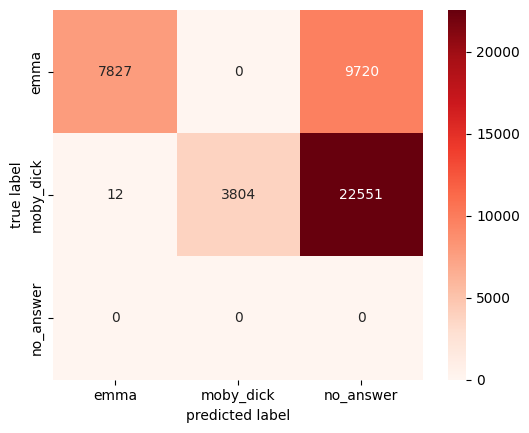

In [43]:
# Check the metrics
if ALEJANDRO:

    acc, prec, rec, f1, conf = get_metrics(targets=kb_df["book"], predictions=kb_df["prediction"])
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1 Score: {f1:.4f}")

    plot_confusion_matrix(conf, labels=["emma", "moby_dick", "no_answer"])

***
## Naive Bayes Classifier
The Naive Bayes Classifier uses Bayes' rule to predict if a given string of text is one of two classes.

$$P(\mathrm{tag} \vert \mathrm{words}) = \frac{P(\mathrm{words} \vert \mathrm{tag}) \times P(\mathrm{tag})}{P(\mathrm{words})}$$

But what exactly are the $\mathrm{words}$ in this case? Sure, we could use the raw counts of each word, but that might not give us enough information. NBC assumes *feature independence* and that the features are unordered (*bag of words*) meaning it does not consider how the probability changes as more words are added. We want words that appear more to have more weight, and we want to capture something about the relationship between these words. This is *feature engineering.*

In [24]:
from sklearn.naive_bayes import (GaussianNB,
                                 BernoulliNB,
                                 MultinomialNB,)

from sklearn.preprocessing import LabelEncoder

from sklearn.pipeline import make_pipeline

from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import (CountVectorizer,
                                             TfidfVectorizer,)

First, let's get our data in a simpler format. Let's start with turning our labels (authors and books) into numbers!

In [25]:
authors = LabelEncoder()
df["author_label"] = authors.fit_transform(df.author)

books = LabelEncoder()
df["book_label"] = authors.fit_transform(df.book)

df.sample(2)

,author,book,line,tokens,author_label,book_label
152437,tolstoy,war_and_peace,“to kill a vicious dog is a very good thing re...,"[“, to, kill, a, vicious, dog, is, a, very, go...",2,11
95822,melville,moby_dick,sir?—clay?,"[sir, ?, —clay, ?]",1,5


First, let's just predict between Jane Austen and Herman Melville. We need to filter our dataset for only these two authors and then create a training-testing split!

In [26]:
nb1_df = df[(df.author == "austen") | (df.author == "melville")]

X_train, X_test, y_train, y_test = train_test_split(nb1_df["line"].to_list(), nb1_df["author_label"].to_list(), train_size=0.7)

print(X_train[0])
print(y_train[0])

print(len(X_train), len(X_test))

and with the knowledge of your ill opinion too!
0
88691 38011


To start off, let's use simple *count-based features*. This means a word's numerical representation is simply the number of times it appears in the dataset.

In [27]:
example = CountVectorizer(max_features=2000, max_df=0.7, ngram_range=(1, 3), stop_words="english")
counts = example.fit_transform(X_train)

print(counts.toarray()[:2])

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


We can combine models and feature preprocessing via *pipelines!*

In [28]:
nb_pipe_01 = make_pipeline(CountVectorizer(max_features=2000, max_df=0.7, ngram_range=(1, 3), stop_words="english"),
                           MultinomialNB())

nb_pipe_01.fit(X=X_train, y=y_train)

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(max_df=0.7, max_features=2000,
                                 ngram_range=(1, 3), stop_words='english')),
                ('multinomialnb', MultinomialNB())])

Let's test it to see how it performs on the training data

In [29]:
predictions = nb_pipe_01.predict(X_test)

Accuracy: 0.8670
Precision: 0.8706
Recall: 0.8672
F1 Score: 0.8667


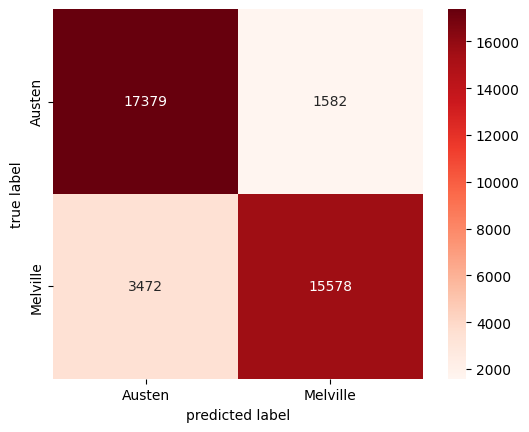

In [44]:
acc, prec, rec, f1, conf = get_metrics(targets=y_test, predictions=predictions)

print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1 Score: {f1:.4f}")

plot_confusion_matrix(conf, labels=["Austen", "Melville"])